<a href="https://colab.research.google.com/github/soykuvvetberat34/Llama_fine_tuning/blob/main/llama_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_name = "microsoft/Phi-3-mini-4k-instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float32,
    device_map="cpu"
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
import json
from datasets import Dataset

# -----------------------------
# 1) JSON VERİYİ YÜKLE
# -----------------------------
with open("data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

ds = Dataset.from_list(data)

# -----------------------------
# 2) INSTRUCTION DATASET DÖNÜŞTÜRÜCÜ
# -----------------------------
def to_text(ex):
    prompt_content = f"""
Aşağıda bir Türk yargı kararı yer almaktadır.

Mahkeme: {ex.get("mahkeme", "Bilinmiyor")}
Hukuk Dairesi: {ex.get("hukukDairesi", "Bilinmiyor")}
Esas No: {ex.get("esasNo", "Bilinmiyor")}
Karar No: {ex.get("kararNo", "Bilinmiyor")}
Karar Tarihi: {ex.get("kararTarihi", "Bilinmiyor")}

KARAR METNİ:
{ex.get("content", "")}

SORU:
Bu kararın ait olduğu hukuk alanını belirt.
Sadece tek bir etiket yaz.
"""

    # Assistant cevabı → mevcut veriden
    response = ex.get("davaTuru", "Bilinmiyor")

    messages = [
        {"role": "user", "content": prompt_content},
        {"role": "assistant", "content": response},
    ]

    return {
        "text": tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=False
        )
    }

# -----------------------------
# 3) DATASET MAP (HATASIZ)
# -----------------------------
dataset = ds.map(
    to_text,
    remove_columns=ds.column_names
)

# -----------------------------
# 4) KONTROL AMAÇLI ÇIKTI
# -----------------------------
print(dataset[0]["text"])
print("\nDataset hazır. Toplam örnek sayısı:", len(dataset))


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

<|user|>

Aşağıda bir Türk yargı kararı yer almaktadır.

Mahkeme: Asliye MAHKEMESİ
Hukuk Dairesi: 4. Ceza Dairesi
Esas No: 2021/5312
Karar No: 2023/1
Karar Tarihi: 2023-03-01

KARAR METNİ:
4. Ceza Dairesi 2021/5312 E. , 2023/1 K. Asliye Ceza Mahkemesi SUÇLAR : Tehdit, hakaret, kasten yaralama, görevi yaptırmamak için direnme, trafik güvenliğini tehlikeye sokma Sanık hakkında görevi yaptırmamak için direnme ve kamu görevlisine görevinden dolayı hakaret suçlarından kurulan hükümlerin temyiz edilmediği belirlenmiştir. Sanık hakkında katılan 'e karşı kasten yaralama suçundan 5271 sayılı Ceza Muhakemesi Kanunu'nun (5271 sayılı Kanun) 231 inci maddesinin beşinci fıkrası uyarınca verilen hükmün açıklanmasının geri bırakılması kararının aynı Kanun'un 231 inci maddesinin onikinci fıkrası gereği itiraz yoluna tabi olduğu, Ağır Ceza Mahkemesinin 2016/259 Değişik İş sayılı kararı ile de itirazın reddine karar verildiği anlaşılmıştır. Katılan vekili, sanık hakkında mala zarar verme suçundan kurulan

In [ ]:
for item in data:
    item["response"] = (
        "Uyuşmazlık Konusu: [Uyuşmazlık konusunu buraya yazın]\n" +
        "Gerekçe: [Gerekçeyi buraya yazın]\n" +
        "Hüküm: [Hükmü buraya yazın]\n" +
        "Hukuk Alanı: [Hukuk alanını buraya yazın]"
    )

In [ ]:
import json
from datasets import Dataset

with open("data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

for item in data:
    item["response"] = (
        "Uyuşmazlık Konusu: [Uyuşmazlık konusunu buraya yazın]\n" +
        "Gerekçe: [Gerekçeyi buraya yazın]\n" +
        "Hüküm: [Hükmü buraya yazın]\n" +
        "Hukuk Alanı: [Hukuk alanını buraya yazın]"
    )

ds = Dataset.from_list(data)

def to_text(ex):
    # Construct the prompt using available keys in 'ex'
    prompt_content = f"""
Aşağıda bir Türk yargı kararı yer almaktadır.

METADATA:
- Hukuk Dairesi: {ex.get("hukukDairesi", "Bilinmiyor")}
- Mahkeme: {ex.get("mahkeme", "Bilinmiyor")}
- Esas No: {ex.get("esasNo", "Bilinmiyor")}
- Karar No: {ex.get("kararNo", "Bilinmiyor")}
- Karar Tarihi: {ex.get("kararTarihi", "Bilinmiyor")}

KARAR METNİ:
{ex.get("content", "")}

Lütfen aşağıdaki formatta cevap ver:

Uyuşmazlık Konusu:
Gerekçe:
Hüküm:
Hukuk Alanı:
"""

    # Check if 'response' key exists in the input data item
    if "response" not in ex:
        raise ValueError(
            "Veri setinizdeki her bir öğe, modelin öğrenmesi gereken beklenen yanıtı içeren 'response' anahtarına sahip olmalıdır. "
            "Lütfen 'data.json' dosyanızı güncelleyin."
        )

    resp = ex["response"]
    if not isinstance(resp, str):
        resp = json.dumps(resp, ensure_ascii=False)

    msgs = [
        {"role": "user", "content": prompt_content},
        {"role": "assistant", "content": resp},
    ]
    return {
        "text": tokenizer.apply_chat_template(
            msgs, tokenize=False, add_generation_prompt=False
        )
    }

dataset = ds.map(to_text, remove_columns=ds.column_names)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
!nvidia-smi


Thu Jan  1 18:45:52 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             41W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
pip install -U unsloth trl peft transformers accelerate


  Using cached trl-0.26.2-py3-none-any.whl.metadata (11 kB)


In [ ]:
# ===============================
# 1) DOĞRU IMPORT SIRASI
# ===============================
import unsloth
from unsloth import FastLanguageModel
import torch

# ===============================
# 2) GPU KONTROL (opsiyonel ama önerilir)
# ===============================
assert torch.cuda.is_available(), "GPU aktif değil! Runtime'ı GPU yap."

# ===============================
# 3) MODELİ UNSLOTH İLE YÜKLE
# ===============================
model_name = "unsloth/Phi-3-mini-4k-instruct-bnb-4bit"

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = 2048,
    dtype = None,          # otomatik
    load_in_4bit = True,   # T4 için şart
)

# ===============================
# 4) LoRA PATCH (FINE-TUNE İÇİN)
# ===============================
model = FastLanguageModel.get_peft_model(
    model,
    r = 64,  # LoRA rank
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_alpha = 128,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
)

# ===============================
# 5) MODELİ EĞİTİME HAZIRLA
# ===============================
FastLanguageModel.for_training(model)

print("✅ Model yüklendi, LoRA eklendi, eğitime hazır.")


/tmp/ipython-input-1525398548.py:4: UserWarning: WARNING: Unsloth should be imported before [transformers] to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  import unsloth


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.12.9: Fast Mistral patching. Transformers: 4.57.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.26G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/194 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/458 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Unsloth 2025.12.9 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


✅ Model yüklendi, LoRA eklendi, eğitime hazır.


In [ ]:
import torch
from unsloth import FastLanguageModel
from trl import SFTTrainer, SFTConfig
from datasets import Dataset
import json
from huggingface_hub import login

# -----------------------------
# 1) HUGGING FACE LOGIN (Llama 3 için gerekli)
# -----------------------------
# Llama 3 kullanmak için token gerekebilir
# login(token="your_huggingface_token")  # Token'ını ekle

# -----------------------------
# 2) DATASET YÜKLE ve FORMATLA
# -----------------------------
# JSON dosyasını yükle
with open("data.json", "r", encoding="utf-8") as f:
    data_list = json.load(f)

# "content" alanını "text" formatına çevir
formatted_data = []
for item in data_list:
    # Hukuki kararı formatla
    text = f"""
Hukuk Dairesi: {item.get('hukukDairesi', '')}
Esas No: {item.get('esasNo', '')}
Karar No: {item.get('kararNo', '')}
Mahkemesi: {item.get('mahkemesi', '')}
Dava Türü: {item.get('davaTuru', '')}
Karar Tarihi: {item.get('kararTarihi', '')}

KARAR METNİ:
{item.get('content', '')}
"""
    formatted_data.append({"text": text.strip()})

# Dataset objesine çevir
dataset = Dataset.from_list(formatted_data)
print(f"Dataset yüklendi: {len(dataset)} hukuki karar örneği")

# Örnek bir kaydı göster
print("\nÖrnek kayıt:")
print(dataset[0]["text"][:500] + "...")

# -----------------------------
# 3) MODELİ YÜKLE
# -----------------------------
model_name = "meta-llama/Meta-Llama-3-8B"
# Alternatif: Erişim sorunu olursa Mistral kullan
# model_name = "mistralai/Mistral-7B-v0.1"

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = 2048,  # Hukuki metinler uzun olabilir
    dtype = None,  # Unsloth otomatik ayarlasın
    load_in_4bit = True,  # Hafıza tasarrufu için
)

# -----------------------------
# 4) LORA EKLE
# -----------------------------
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    lora_alpha = 32,
    lora_dropout = 0,
    target_modules = [
        "q_proj", "k_proj", "v_proj",
        "o_proj", "gate_proj", "up_proj", "down_proj"
    ],
    bias = "none",
    use_gradient_checkpointing = True,
)

# -----------------------------
# 5) TOKENIZER AYARLA (Türkçe için)
# -----------------------------
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# -----------------------------
# 6) TRAINER
# -----------------------------
trainer = SFTTrainer(
    model = model,
    train_dataset = dataset,
    tokenizer = tokenizer,
    dataset_text_field = "text",
    max_seq_length = 2048,
    args = SFTConfig(
        output_dir = "hukuk_model_output",
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        num_train_epochs = 3,
        max_steps = 100,  # Dataset boyutuna göre ayarla
        logging_steps = 10,
        optim = "adamw_8bit",

        # Unsloth log'una göre ayarla
        fp16 = False,
        bf16 = True,

        # Hukuki metinler için uygun learning rate
        learning_rate = 1e-4,
        warmup_steps = 20,
        save_strategy = "steps",
        save_steps = 50,
        gradient_checkpointing = True,
        gradient_checkpointing_kwargs = {"use_reentrant": False},

        # Türkçe metinler için
        group_by_length = True,  # Benzer uzunluktaki metinleri grupla
        packing = False,  # Hukuki metinler için packing kapalı daha iyi
    ),
)

# -----------------------------
# 7) EĞİTİM
# -----------------------------
print("\n" + "="*50)
print("HUKUKİ KARAR MODELİ EĞİTİMİ BAŞLIYOR")
print("="*50)
trainer.train()

# -----------------------------
# 8) MODELİ KAYDET
# -----------------------------
output_dir = "hukuk_karar_model"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"\nModel başarıyla kaydedildi: {output_dir}")

# -----------------------------
# 9) TEST ET
# -----------------------------
print("\n" + "="*50)
print("MODEL TESTİ")
print("="*50)

# Test için prompt
test_prompt = """Hukuk Dairesi: 8. Hukuk Dairesi
Esas No: 2023/8
Karar No: 2023/2
Mahkemesi: Asliye Hukuk Mahkemesi
Dava Türü: Mülkiyet davası

KARAR METNİ:"""

inputs = tokenizer(test_prompt, return_tensors="pt", truncation=True, max_length=512)
inputs = {k: v.to(model.device) for k, v in inputs.items()}

# Generate
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=200,
        temperature=0.7,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id,
    )

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Üretilen metin:")
print(generated_text)

Dataset yüklendi: 100 hukuki karar örneği

Örnek kayıt:
Hukuk Dairesi: 4. Ceza Dairesi
Esas No: 2021/5312
Karar No: 2023/1
Mahkemesi: Asliye Ceza Mahkemesi
Dava Türü: Ceza, Hakaret (Güvenilirlik: Ceza: %100 | Hakaret: %100)
Karar Tarihi: 2023-03-01

KARAR METNİ:
4. Ceza Dairesi 2021/5312 E. , 2023/1 K. Asliye Ceza Mahkemesi SUÇLAR : Tehdit, hakaret, kasten yaralama, görevi yaptırmamak için direnme, trafik güvenliğini tehlikeye sokma Sanık hakkında görevi yaptırmamak için direnme ve kamu görevlisine görevinden dolayı hakaret suçlarından kurulan hüküml...
==((====))==  Unsloth 2025.12.9: Fast Llama patching. Transformers: 4.57.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading

model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/100 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


🦥 Unsloth: Padding-free auto-enabled, enabling faster training.

HUKUKİ KARAR MODELİ EĞİTİMİ BAŞLIYOR


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 100 | Num Epochs = 8 | Total steps = 100
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)


Step,Training Loss
10,1.645800
20,1.271800
30,0.955300
40,0.786100
50,0.660600
60,0.605800
70,0.487500
80,0.501600
90,0.374100
100,0.414900



Model başarıyla kaydedildi: hukuk_karar_model

MODEL TESTİ
Üretilen metin:
Hukuk Dairesi: 8. Hukuk Dairesi
Esas No: 2023/8
Karar No: 2023/2
Mahkemesi: Asliye Hukuk Mahkemesi
Dava Türü: Mülkiyet davası

KARAR METNİ: 8. Hukuk Dairesi 2023/8 E., 2023/2 K. Asliye Hukuk Mahkemesi 2797 sayılı Yargıtay Kanunu'nun (2797 sayılı Kanun) 40 ıncı ve Yargıtay İç Yönetmeliği'nin 18 inci maddeleri uyarınca yapılan ön incelemede; dava konusu uyuşmazlığın niteliği ve temyizin kapsamının tapu kayıtlarının tespisi isteğine ilişkin olduğu anlaşılmıştır. Yargıtay Büyük Genel Kurulunun dairelerin iş bölümüne ilişkin 26. 01. 2023 tarihli ve 1 sayılı kararı uyarınca dosyayı inceleme görevi Yargıtay (7). Hukuk Dairesine ait olduğundan, 2797 sayılı Kanun'un 60 ıncı maddesinin üçüncü fıkrası uyarınca gerekli inceleme yapılm


In [ ]:
import torch
from unsloth import FastLanguageModel

# 1) Modeli inference moduna al
model = FastLanguageModel.for_inference(model)

# 2) Örnek karar verisi
case_data = {
    "hukukDairesi": "8. Hukuk Dairesi",
    "mahkeme": "Asliye Hukuk Mahkemesi",
    "esasNo": "2023/8",
    "kararNo": "2023/2",
    "kararTarihi": "2023-05-01",
    "content": "8. Hukuk Dairesi 2023/8 E., 2023/2 K. Asliye Hukuk Mahkemesi 2797 sayılı Yargıtay Kanunu'nun (2797 sayılı Kanun) 40 ıncı ve Yargıtay İç Yönetmeliği'nin 18 inci maddeleri uyarınca yapılan ön incelemede; dava konusu uyuşmazlığın niteliği ve temyizin kapsamının mülkiyet hakkına dayalı elatmanın önlenmesi, yıkım ve ecrimisil isteğine ilişkin olduğu anlaşılmıştır. Yargıtay Büyük Genel Kurulunun dairelerin iş bölümüne ilişkin 26. 01. 2022 tarihli ve 1 sayılı kararı uyarınca dosyayı inceleme görevi Yargıtay (7). Hukuk Dairesine ait olduğundan, 2797 sayılı Kanun'un 60 ıncı maddesinin üçüncü fıkrası uyarınca gerekli inceleme yapılmak üzere dosyanın ilgili daireye gönderilmesine karar vermek gerekir. KARAR Açıklanan sebeple; Dosyanın YARGITAY (7). HUKUK DAİRESİNE GÖNDERİLMESİNE, 05. 01. 2023 tarihinde oy birliğiyle karar verildi."
}

# 3) PROMPT DOĞRUDAN OLUŞTUR (chat template kullanmadan)
prompt = f"""Aşağıda bir Türk yargı kararı yer almaktadır.

METADATA:
- Hukuk Dairesi: {case_data["hukukDairesi"]}
- Mahkeme: {case_data["mahkeme"]}
- Esas No: {case_data["esasNo"]}
- Karar No: {case_data["kararNo"]}
- Karar Tarihi: {case_data["kararTarihi"]}

KARAR METNİ:
{case_data["content"]}

Lütfen aşağıdaki formatta cevap ver:

Uyuşmazlık Konusu:
Gerekçe:
Hüküm:
Hukuk Alanı:"""

print("=" * 60)
print("PROMPT (İlk 200 karakter):")
print("=" * 60)
print(prompt[:200] + "...")
print("\n")

# 4) TOKENIZE (Normal tokenize kullan)
inputs = tokenizer(
    prompt,
    return_tensors="pt",
    truncation=True,
    max_length=1024
)

# GPU'ya gönder
inputs = {k: v.to("cuda") for k, v in inputs.items()}

# 5) GENERATE
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=300,
        temperature=0.7,
        do_sample=True,
        top_p=0.9,
        pad_token_id=tokenizer.eos_token_id
    )

# 6) SADECE YENİ TOKEN'LARI DECODE ET
input_len = inputs["input_ids"].shape[1]
generated_tokens = outputs[0][input_len:]

response = tokenizer.decode(
    generated_tokens,
    skip_special_tokens=True
)

print("=" * 60)
print("MODEL CEVABI")
print("=" * 60)
print(response.strip())

PROMPT (İlk 200 karakter):
Aşağıda bir Türk yargı kararı yer almaktadır.

METADATA:
- Hukuk Dairesi: 8. Hukuk Dairesi
- Mahkeme: Asliye Hukuk Mahkemesi
- Esas No: 2023/8
- Karar No: 2023/2
- Karar Tarihi: 2023-05-01

KARAR METN...


MODEL CEVABI
KARAR METNİ:


In [ ]:
model.save_pretrained_gguf("gguf_model_scratch_fixed", tokenizer, quantization_method="q4_k_m", maximum_memory_usage = 0.3)

Unsloth: Merging model weights to 16-bit format...


config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Checking cache directory for required files...
Cache check failed: model-00001-of-00004.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  25%|██▌       | 1/4 [00:13<00:39, 13.15s/it]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  50%|█████     | 2/4 [00:28<00:28, 14.45s/it]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  75%|███████▌  | 3/4 [00:52<00:18, 18.72s/it]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files: 100%|██████████| 4/4 [01:18<00:00, 19.64s/it]


Note: tokenizer.model not found (this is OK for non-SentencePiece models)


Unsloth: Merging weights into 16bit: 100%|██████████| 4/4 [00:55<00:00, 13.82s/it]


Unsloth: Merge process complete. Saved to `/content/gguf_model_scratch_fixed`
Unsloth: Converting to GGUF format...
==((====))==  Unsloth: Conversion from HF to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF bf16 might take 3 minutes.
\        /    [2] Converting GGUF bf16 to ['q4_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: Updating system package directories
Unsloth: All required system packages already installed!
Unsloth: Install llama.cpp and building - please wait 1 to 3 minutes
Unsloth: Cloning llama.cpp repository
Unsloth: Install GGUF and other packages
Unsloth: Successfully installed llama.cpp!
Unsloth: Preparing converter script...
Unsloth: [1] Converting model into bf16 GGUF format.
This might take 3 minutes...
Unsloth: Initial conversion completed! Files: ['llama-3-8b.BF16.gguf']


{'save_directory': 'gguf_model_scratch_fixed',
 'gguf_files': ['llama-3-8b.Q4_K_M.gguf'],
 'modelfile_location': None,
 'want_full_precision': False,
 'is_vlm': False,
 'fix_bos_token': False}

In [ ]:
import torch
import json
import re
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from unsloth import FastLanguageModel

print("="*60)
print("BASIT MODEL DEĞERLENDİRMESİ")
print("="*60)

# 1) Veriyi yükle
with open("data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

print(f"Toplam veri: {len(data)} kayıt")

# 2) Modeli yükle
model_path = "hukuk_karar_model"
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_path,
    max_seq_length=2048,
    dtype=None,
    load_in_4bit=True,
)
model = FastLanguageModel.for_inference(model)

print("Model yüklendi ✓")

# 3) Basit etiket çıkarma fonksiyonu
def basit_etiket_cikar(text):
    text_lower = text.lower()

    hukuk_alanlari = {
        "mülkiyet": ["mülkiyet", "irtifak", "ecrimisil", "taşınmaz"],
        "borç": ["borç", "tazminat", "sözleşme"],
        "aile": ["boşanma", "nafaka", "velayet"],
        "iş": ["iş", "ihbar", "kıdem"],
        "icra": ["icra", "iflâs", "takip"],
        "diğer": []
    }

    for alan, kelimeler in hukuk_alanlari.items():
        for kelime in kelimeler:
            if kelime in text_lower:
                return alan
    return "diğer"

# 4) Test için ilk 30 kaydı al
test_data = data[:30]
print(f"\n{len(test_data)} kayıt ile test ediliyor...")

# 5) Modeli test et
dogru_tahminler = 0
tum_tahminler = []
tum_gercekler = []

for i, item in enumerate(tqdm(test_data, desc="Test")):
    try:
        # Gerçek etiket
        gercek_etiket = basit_etiket_cikar(item["content"])

        # Model için prompt
        prompt = f"""Aşağıdaki hukuki karar metninin hukuk alanı nedir?

{item['content'][:800]}...

Cevabı sadece hukuk alanını yazarak verin:"""

        # Modeli sorgula
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=20,
                temperature=0.1,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id,
            )

        # Cevabı al
        cevap = tokenizer.decode(outputs[0], skip_special_tokens=True)
        cevap = cevap.replace(prompt, "").strip().lower()

        # Tahmin edilen etiket
        tahmin_edilen = "diğer"
        for alan in ["mülkiyet", "borç", "aile", "iş", "icra"]:
            if alan in cevap:
                tahmin_edilen = alan
                break

        # Karşılaştır
        tum_tahminler.append(tahmin_edilen)
        tum_gercekler.append(gercek_etiket)

        if tahmin_edilen == gercek_etiket:
            dogru_tahminler += 1

        # İlk 5 kaydı göster
        if i < 5:
            print(f"\nÖrnek {i+1}:")
            print(f"Gerçek: {gercek_etiket}")
            print(f"Tahmin: {tahmin_edilen}")
            print(f"Cevap: {cevap[:50]}...")
            print(f"Eşleşme: {'✓' if tahmin_edilen == gercek_etiket else '✗'}")

    except Exception as e:
        print(f"\nHata: {str(e)}")
        tum_tahminler.append("diğer")
        tum_gercekler.append("diğer")

# 6) Metrikleri hesapla
print("\n" + "="*60)
print("SONUÇLAR")
print("="*60)

# Accuracy
accuracy = accuracy_score(tum_gercekler, tum_tahminler)
print(f"Accuracy: {accuracy:.4f} ({dogru_tahminler}/{len(test_data)})")

# Precision, Recall, F1
precision = precision_score(tum_gercekler, tum_tahminler, average='weighted', zero_division=0)
recall = recall_score(tum_gercekler, tum_tahminler, average='weighted', zero_division=0)
f1 = f1_score(tum_gercekler, tum_tahminler, average='weighted', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# 7) Karışıklık matrisi (basit)
print("\n" + "="*60)
print("KARIŞIKLIK MATRİSİ")
print("="*60)

alanlar = sorted(set(tum_gercekler + tum_tahminler))
print("\n" + " " * 10 + " ".join(f"{alan[:8]:>8}" for alan in alanlar))

for i, gercek in enumerate(alanlar):
    satir = f"{gercek[:8]:<10}"
    for j, tahmin in enumerate(alanlar):
        say = sum(1 for g, t in zip(tum_gercekler, tum_tahminler)
                 if g == gercek and t == tahmin)
        satir += f"{say:>8}"
    print(satir)

# 8) Sınıf bazlı performans
print("\n" + "="*60)
print("SINIF BAZLI PERFORMANS")
print("="*60)

for alan in alanlar:
    if alan == "diğer":
        continue

    # Bu alan için binary classification
    y_true_binary = [1 if g == alan else 0 for g in tum_gercekler]
    y_pred_binary = [1 if t == alan else 0 for t in tum_tahminler]

    tp = sum(1 for t, p in zip(y_true_binary, y_pred_binary) if t == 1 and p == 1)
    fp = sum(1 for t, p in zip(y_true_binary, y_pred_binary) if t == 0 and p == 1)
    fn = sum(1 for t, p in zip(y_true_binary, y_pred_binary) if t == 1 and p == 0)

    precision_class = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_class = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_class = 2 * (precision_class * recall_class) / (precision_class + recall_class) if (precision_class + recall_class) > 0 else 0

    print(f"\n{alan.capitalize():<12} Precision: {precision_class:.3f} | Recall: {recall_class:.3f} | F1: {f1_class:.3f}")

# 9) Özet
print("\n" + "="*60)
print("ÖZET")
print("="*60)
print(f"Test edilen örnek sayısı: {len(test_data)}")
print(f"Doğru tahmin sayısı: {dogru_tahminler}")
print(f"Doğruluk (Accuracy): %{accuracy*100:.1f}")
print(f"F1-Score: {f1:.3f}")

# Kaydet
with open("degerlendirme_sonuclari.txt", "w", encoding="utf-8") as f:
    f.write(f"Model Değerlendirme Sonuçları\n")
    f.write("="*40 + "\n")
    f.write(f"Test Örnek Sayısı: {len(test_data)}\n")
    f.write(f"Doğru Tahmin: {dogru_tahminler}\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1-Score: {f1:.4f}\n")

print("\nSonuçlar 'degerlendirme_sonuclari.txt' dosyasına kaydedildi.")

BASIT MODEL DEĞERLENDİRMESİ
Toplam veri: 100 kayıt
==((====))==  Unsloth 2025.12.9: Fast Llama patching. Transformers: 4.57.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
unsloth/llama-3-8b-bnb-4bit does not have a padding token! Will use pad_token = <|reserved_special_token_250|>.
Model yüklendi ✓

30 kayıt ile test ediliyor...


Test:   3%|▎         | 1/30 [00:00<00:13,  2.18it/s]


Örnek 1:
Gerçek: iş
Tahmin: iş
Cevap: aşağıdaki hukuki karar metninin hukuk alanı nedir?...
Eşleşme: ✓


Test:   7%|▋         | 2/30 [00:01<00:26,  1.04it/s]


Örnek 2:
Gerçek: mülkiyet
Tahmin: mülkiyet
Cevap: aşağıdaki hukuki karar metninin hukuk alanı nedir?...
Eşleşme: ✓


Test:  10%|█         | 3/30 [00:03<00:30,  1.12s/it]


Örnek 3:
Gerçek: borç
Tahmin: iş
Cevap: aşağıdaki hukuki karar metninin hukuk alanı nedir?...
Eşleşme: ✗


Test:  13%|█▎        | 4/30 [00:04<00:30,  1.19s/it]


Örnek 4:
Gerçek: iş
Tahmin: iş
Cevap: aşağıdaki hukuki karar metninin hukuk alanı nedir?...
Eşleşme: ✓


Test:  20%|██        | 6/30 [00:05<00:20,  1.17it/s]


Örnek 5:
Gerçek: iş
Tahmin: iş
Cevap: aşağıdaki hukuki karar metninin hukuk alanı nedir?...
Eşleşme: ✓


Test: 100%|██████████| 30/30 [00:30<00:00,  1.03s/it]


SONUÇLAR
Accuracy: 0.7000 (21/30)
Precision: 0.7458
Recall: 0.7000
F1-Score: 0.6583

KARIŞIKLIK MATRİSİ

              borç       iş mülkiyet
borç             0       2       0
iş               0      15       0
mülkiyet         0       7       6

SINIF BAZLI PERFORMANS

Borç         Precision: 0.000 | Recall: 0.000 | F1: 0.000

Iş           Precision: 0.625 | Recall: 1.000 | F1: 0.769

Mülkiyet     Precision: 1.000 | Recall: 0.462 | F1: 0.632

ÖZET
Test edilen örnek sayısı: 30
Doğru tahmin sayısı: 21
Doğruluk (Accuracy): %70.0
F1-Score: 0.658

Sonuçlar 'degerlendirme_sonuclari.txt' dosyasına kaydedildi.


In [ ]:
import os

print("Searching for .gguf files in /content/ directory...")
gguf_files_found = []
for root, dirs, files in os.walk('/content/'):
    for file in files:
        if file.endswith('.gguf'):
            gguf_files_found.append(os.path.join(root, file))

if gguf_files_found:
    print("Found .gguf files:")
    for f in gguf_files_found:
        print(f)
    print("\nBu dosyaları indirmek için sol taraftaki dosya simgesine tıklayıp, ilgili klasörü açarak dosyayı sağ tıklayıp 'İndir' seçeneğini kullanabilirsiniz.")
else:
    print("No .gguf files found in /content/.")

Searching for .gguf files in /content/ directory...
Found .gguf files:
/content/llama-3-8b.Q4_K_M.gguf
/content/llama.cpp/models/ggml-vocab-gpt-neox.gguf
/content/llama.cpp/models/ggml-vocab-mpt.gguf
/content/llama.cpp/models/ggml-vocab-nomic-bert-moe.gguf
/content/llama.cpp/models/ggml-vocab-deepseek-coder.gguf
/content/llama.cpp/models/ggml-vocab-aquila.gguf
/content/llama.cpp/models/ggml-vocab-gpt-2.gguf
/content/llama.cpp/models/ggml-vocab-phi-3.gguf
/content/llama.cpp/models/ggml-vocab-starcoder.gguf
/content/llama.cpp/models/ggml-vocab-deepseek-llm.gguf
/content/llama.cpp/models/ggml-vocab-baichuan.gguf
/content/llama.cpp/models/ggml-vocab-llama-bpe.gguf
/content/llama.cpp/models/ggml-vocab-command-r.gguf
/content/llama.cpp/models/ggml-vocab-refact.gguf
/content/llama.cpp/models/ggml-vocab-llama-spm.gguf
/content/llama.cpp/models/ggml-vocab-falcon.gguf
/content/llama.cpp/models/ggml-vocab-bert-bge.gguf
/content/llama.cpp/models/ggml-vocab-qwen2.gguf

Bu dosyaları indirmek için so

TOKEN KULLANIMI ve SORGULAR
==((====))==  Unsloth 2025.12.9: Fast Llama patching. Transformers: 4.57.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
unsloth/llama-3-8b-bnb-4bit does not have a padding token! Will use pad_token = <|reserved_special_token_250|>.
✓ Model yüklendi

SORGU 1

1. Sorgu (Basit):
Prompt: Bu hukuki karar hangi alana girer?
    
4. Ceza Dairesi 2021/5312 E. , 2023/1 K....
Cevap: Bu hukuki karar hangi alana girer?
    
4. Ceza Dairesi 2021/5312 E., 2023/1 K. Asliye Ceza Mahkemes...
Token: 174 input + 173 output = 347 total

2. Sorgu (Detaylı):
Prompt: Aşağıdaki hukuki kararı analiz edin:

4. Ceza Dairesi 2021/5312 E. , 202

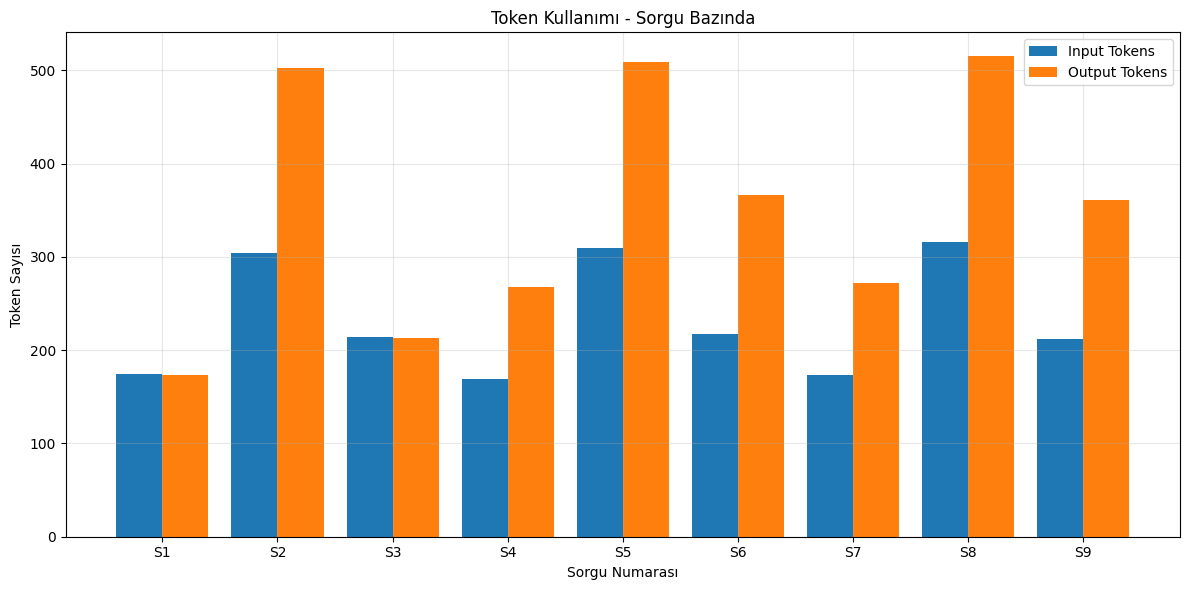

In [ ]:
import torch
from unsloth import FastLanguageModel
import json

print("="*60)
print("TOKEN KULLANIMI ve SORGULAR")
print("="*60)

# Modeli yükle
model_path = "hukuk_karar_model"
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_path,
    max_seq_length=2048,
    dtype=None,
    load_in_4bit=True,
)
model = FastLanguageModel.for_inference(model)

print("✓ Model yüklendi")

# Test verilerini yükle
with open("data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# İlk 3 hukuki kararı al
test_cases = data[:3]

class TokenAnalyzer:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.total_requests = 0
        self.token_stats = []

    def analyze_request(self, prompt, response, case_info=None):
        """Bir sorguyu analiz et"""

        # Token hesaplamaları
        input_tokens = len(self.tokenizer.encode(prompt))
        output_tokens = len(self.tokenizer.encode(response))
        total_tokens = input_tokens + output_tokens

        # Maliyet hesaplama (OpenAI fiyatları)
        input_cost = (input_tokens / 1000) * 0.50  # $0.50 per 1K
        output_cost = (output_tokens / 1000) * 1.50  # $1.50 per 1K
        total_cost = input_cost + output_cost

        stats = {
            "request_id": self.total_requests + 1,
            "input_tokens": input_tokens,
            "output_tokens": output_tokens,
            "total_tokens": total_tokens,
            "input_cost": input_cost,
            "output_cost": output_cost,
            "total_cost": total_cost,
            "prompt_preview": prompt[:100] + "..." if len(prompt) > 100 else prompt,
            "response_preview": response[:100] + "..." if len(response) > 100 else response,
            "full_response": response,
            "case_info": case_info
        }

        self.token_stats.append(stats)
        self.total_requests += 1

        return stats

    def print_summary(self):
        """Özet raporu yazdır"""
        print("\n" + "="*60)
        print("TOKEN KULLANIM ÖZETİ")
        print("="*60)

        total_input = sum(s["input_tokens"] for s in self.token_stats)
        total_output = sum(s["output_tokens"] for s in self.token_stats)
        total_all = total_input + total_output
        total_cost = sum(s["total_cost"] for s in self.token_stats)

        print(f"Toplam İstek Sayısı: {self.total_requests}")
        print(f"Toplam Input Token: {total_input:,}")
        print(f"Toplam Output Token: {total_output:,}")
        print(f"Toplam Token: {total_all:,}")
        print(f"\nTahmini Maliyet (OpenAI fiyatlarıyla): ${total_cost:.6f}")

        # Ortalama token sayıları
        avg_input = total_input / self.total_requests
        avg_output = total_output / self.total_requests
        print(f"\nOrtalama Input Token/istek: {avg_input:.0f}")
        print(f"Ortalama Output Token/istek: {avg_output:.0f}")

        return {
            "total_requests": self.total_requests,
            "total_tokens": total_all,
            "total_cost": total_cost
        }

# Token analyzer oluştur
analyzer = TokenAnalyzer(tokenizer)

# 3 farklı sorgu yap
for i, case in enumerate(test_cases):
    print(f"\n{'='*60}")
    print(f"SORGU {i+1}")
    print(f"{'='*60}")

    # Sorgu 1: Basit analiz
    prompt1 = f"""Bu hukuki karar hangi alana girer?

{case['content'][:500]}..."""

    inputs1 = tokenizer(prompt1, return_tensors="pt", truncation=True, max_length=1024)
    inputs1 = {k: v.to(model.device) for k, v in inputs1.items()}

    with torch.no_grad():
        outputs1 = model.generate(**inputs1, max_new_tokens=100, temperature=0.3)

    response1 = tokenizer.decode(outputs1[0], skip_special_tokens=True)
    response1 = response1.replace(prompt1, "").strip()

    # Analiz et
    stats1 = analyzer.analyze_request(
        prompt1,
        response1,
        case_info=f"Sorgu {i+1}-1: Basit alan tespiti"
    )

    print(f"\n1. Sorgu (Basit):")
    print(f"Prompt: {prompt1[:80]}...")
    print(f"Cevap: {response1[:100]}...")
    print(f"Token: {stats1['input_tokens']} input + {stats1['output_tokens']} output = {stats1['total_tokens']} total")

    # Sorgu 2: Detaylı analiz
    prompt2 = f"""Aşağıdaki hukuki kararı analiz edin:

{case['content'][:800]}...

Lütfen şu başlıklarda cevap verin:
1. Dava Türü
2. Ana Konu
3. Karar Sonucu
4. İlgili Kanun Maddeleri"""

    inputs2 = tokenizer(prompt2, return_tensors="pt", truncation=True, max_length=1024)
    inputs2 = {k: v.to(model.device) for k, v in inputs2.items()}

    with torch.no_grad():
        outputs2 = model.generate(**inputs2, max_new_tokens=200, temperature=0.4)

    response2 = tokenizer.decode(outputs2[0], skip_special_tokens=True)
    response2 = response2.replace(prompt2, "").strip()

    stats2 = analyzer.analyze_request(
        prompt2,
        response2,
        case_info=f"Sorgu {i+1}-2: Detaylı analiz"
    )

    print(f"\n2. Sorgu (Detaylı):")
    print(f"Prompt: {prompt2[:80]}...")
    print(f"Cevap: {response2[:150]}...")
    print(f"Token: {stats2['input_tokens']} input + {stats2['output_tokens']} output = {stats2['total_tokens']} total")

    # Sorgu 3: Özet çıkarma
    prompt3 = f"""Bu hukuki kararı özetleyin:

{case['content'][:600]}...

Özeti maksimum 3 cümle ile verin."""

    inputs3 = tokenizer(prompt3, return_tensors="pt", truncation=True, max_length=1024)
    inputs3 = {k: v.to(model.device) for k, v in inputs3.items()}

    with torch.no_grad():
        outputs3 = model.generate(**inputs3, max_new_tokens=150, temperature=0.5)

    response3 = tokenizer.decode(outputs3[0], skip_special_tokens=True)
    response3 = response3.replace(prompt3, "").strip()

    stats3 = analyzer.analyze_request(
        prompt3,
        response3,
        case_info=f"Sorgu {i+1}-3: Özet çıkarma"
    )

    print(f"\n3. Sorgu (Özet):")
    print(f"Prompt: {prompt3[:80]}...")
    print(f"Cevap: {response3}")
    print(f"Token: {stats3['input_tokens']} input + {stats3['output_tokens']} output = {stats3['total_tokens']} total")

# Tüm sorguların tam cevaplarını göster
print("\n" + "="*60)
print("TÜM SORGULARIN TAM CEVAPLARI")
print("="*60)

for i, stats in enumerate(analyzer.token_stats):
    print(f"\n{'='*40}")
    print(f"SORGU {stats['request_id']} - {stats['case_info']}")
    print(f"{'='*40}")
    print(f"Input Token: {stats['input_tokens']}")
    print(f"Output Token: {stats['output_tokens']}")
    print(f"Toplam Token: {stats['total_tokens']}")
    print(f"Tahmini Maliyet: ${stats['total_cost']:.6f}")
    print(f"\nCEVAP:")
    print(stats['full_response'])
    print(f"\n{'~'*40}")

# Özet raporu
summary = analyzer.print_summary()

# Token kullanım grafiği (opsiyonel)
try:
    import matplotlib.pyplot as plt

    # Token kullanımı grafiği
    requests = [f"S{s['request_id']}" for s in analyzer.token_stats]
    input_tokens = [s['input_tokens'] for s in analyzer.token_stats]
    output_tokens = [s['output_tokens'] for s in analyzer.token_stats]

    x = range(len(requests))

    plt.figure(figsize=(12, 6))
    plt.bar(x, input_tokens, width=0.4, label='Input Tokens', align='center')
    plt.bar([i + 0.4 for i in x], output_tokens, width=0.4, label='Output Tokens', align='center')

    plt.xlabel('Sorgu Numarası')
    plt.ylabel('Token Sayısı')
    plt.title('Token Kullanımı - Sorgu Bazında')
    plt.xticks([i + 0.2 for i in x], requests)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('token_kullanimi.png', dpi=100)
    print("\n✓ Token kullanım grafiği 'token_kullanimi.png' olarak kaydedildi")

except ImportError:
    print("\n⚠ Matplotlib yüklü değil, grafik oluşturulamadı")

# CSV olarak kaydet
import pandas as pd
df = pd.DataFrame(analyzer.token_stats)
df.to_csv('token_analiz.csv', index=False, encoding='utf-8-sig')
print("✓ Detaylı analiz 'token_analiz.csv' olarak kaydedildi")

print("\n" + "="*60)
print("ANALİZ TAMAMLANDI")
print("="*60)

In [ ]:
def calculate_training_tokens(dataset_path="data.json", epochs=3):
    """
    Model eğitimi için token hesaplama
    """
    import json

    with open(dataset_path, "r") as f:
        data = json.load(f)

    # Dataset'teki toplam karakter
    total_chars = sum(len(str(item.get("content", ""))) for item in data)

    # Ortalama token/karakter oranı (Türkçe için ~0.25)
    avg_tokens_per_char = 0.25
    tokens_per_epoch = total_chars * avg_tokens_per_char

    # Toplam eğitim token'ları
    total_training_tokens = tokens_per_epoch * epochs

    print(f"\nEĞİTİM TOKEN HESAPLAMASI")
    print(f"{'='*50}")
    print(f"Dataset kayıt sayısı: {len(data)}")
    print(f"Toplam karakter: {total_chars:,}")
    print(f"Token/karakter oranı: {avg_tokens_per_char}")
    print(f"Epoch başı token: {tokens_per_epoch:,.0f}")
    print(f"Toplam epoch: {epochs}")
    print(f"Toplam eğitim token: {total_training_tokens:,.0f}")
    print(f"Bu yaklaşık {total_training_tokens/1_000_000:.2f}M token")

    # Eğitim maliyeti (OpenAI fine-tuning fiyatları)
    training_cost_per_1m = 3.00  # $ per 1M tokens (training)
    estimated_cost = (total_training_tokens / 1_000_000) * training_cost_per_1m

    print(f"\nOpenAI ile fine-tuning yapılsaydı:")
    print(f"  Tahmini maliyet: ${estimated_cost:.2f}")
    print(f"  Tasarruf: %100 (local eğitim)")

    return total_training_tokens

# Hesapla
training_tokens = calculate_training_tokens("data.json", epochs=3)


EĞİTİM TOKEN HESAPLAMASI
Dataset kayıt sayısı: 100
Toplam karakter: 353,736
Token/karakter oranı: 0.25
Epoch başı token: 88,434
Toplam epoch: 3
Toplam eğitim token: 265,302
Bu yaklaşık 0.27M token

OpenAI ile fine-tuning yapılsaydı:
  Tahmini maliyet: $0.80
  Tasarruf: %100 (local eğitim)


In [ ]:
import torch

# Inference'ta kullandığın değerle AYNI olsun
max_new_tokens = 512

# Unsloth model varsa tokenizer buradan gelir
tokenizer = model.tokenizer if hasattr(model, "tokenizer") else tokenizer

prompt_text = """Aşağıda bir Türk yargı kararı yer almaktadır..."""

# Token sayısı (transformers tokenizer ile)
input_ids = tokenizer(
    prompt_text,
    return_tensors="pt",
    truncation=False
)["input_ids"]

token_count = input_ids.shape[1]

print(f"Prompt token sayısı: {token_count}")
print(f"Modelin üreteceği max token: {max_new_tokens}")
print(f"Toplam token (context): {token_count + max_new_tokens}")


Prompt token sayısı: 14
Modelin üreteceği max token: 512
Toplam token (context): 526
